# Time series clustering exercise

# Data

Download the census bureau business data for all years 1993-2014. You can investigate using the API (I have not done it with the census bureau). I did is as you see below

The data is on the github repo. Each file is the economic census for 1 year. 
Download it programmatically and move it to PUIdata

 Download the NYC zipcodes shapefile. One of many ways in which you can get the zipcodes shapefile for NYC
 https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip


## You can use zipfile module in python to unzip the files
it should be installed in your system, but if it is not you can get the code with wget from here
https://github.com/python/cpython/blob/2.7/Lib/zipfile.py
remembering to use the raw link
(or you can use the usual shell commands)

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%%capture
!wget -O "zipcode.zip" "https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip"
!mv "zipcode.zip" "$PUIDATA"
!unzip -o "$PUIDATA/zipcode.zip" -d "$PUIDATA"

In [3]:
'''import pandas as pd
import zipfile 
zf = zipfile.ZipFile(fname)
df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))

with zipfile.ZipFile(fname, 'r') as zf:
    zf.extractall(os.getenv("PUIDATA"))'''

'import pandas as pd\nimport zipfile \nzf = zipfile.ZipFile(fname)\ndf = pd.read_csv(zf.open(fname.replace(\'.zip\',\'.txt\')))\n\nwith zipfile.ZipFile(fname, \'r\') as zf:\n    zf.extractall(os.getenv("PUIDATA"))'

In [4]:
years = []
for i in range(1994,2015):
    print(str(i)[2:])
    years.append(str(i)[2:])
    
for year in years:
    os.system("wget https://github.com/fedhere/PUI2018_fb55/raw/master/HW12_fb55/zbp" + year + "totals.zip")

94
95
96
97
98
99
00
01
02
03
04
05
06
07
08
09
10
11
12
13
14


In [5]:
%%capture
!mv zbp* "$PUIDATA"
!unzip "$PUIDATA/zbp*.zip" -d "$PUIDATA"

In [6]:
dfs = []
for year,n_year in zip(years,range(1994,2015)):
    df = pd.read_csv(os.getenv("PUIDATA") + "/zbp" + year + "totals.zip", dtype = {"zip": str})
    df["year"] = n_year
    df.columns = map(str.lower, df.columns)
    dfs.append(df)

dfs = pd.concat(dfs, ignore_index=True)

In [7]:
dfs.head()

,ap,ap_nf,city,cty_name,emp,emp_nf,empflag,est,name,qp1,qp1_nf,stabbr,year,zip
0,155158,NaN,NaN,NaN,6198,NaN,NaN,439,"Agawam, MA",33601,NaN,NaN,1994,01001
1,127367,NaN,NaN,NaN,6073,NaN,NaN,450,"Amherst, MA",28924,NaN,NaN,1994,01002
2,1604,NaN,NaN,NaN,68,NaN,NaN,10,"Amherst, MA",367,NaN,NaN,1994,01003
3,4302,NaN,NaN,NaN,210,NaN,NaN,47,"Amherst, MA",844,NaN,NaN,1994,01004
4,13521,NaN,NaN,NaN,678,NaN,NaN,92,"Barre, MA",3010,NaN,NaN,1994,01005


# Data cleaning

you may need to clean your data: for some NYC zip codes there may be no info
sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)


IMPORTANT: read the instructions below on pre-processing. Afte rthat:

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



## TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means
    in **a few** clusters (as discussed there is no real good, sound way to 
    decide what a good number is here. try a few options, keeping in mind 
    a few is more than a couple, but i recommand you stay within the 
    single digit numbers)
    
    3. plot the cluster centers (if you used K means those are the means of 
    the clusters). you can plot for example the cluster centers overlayed on 
    each time series (using the alpha channel to control the opacity in the 
    plot may be helpful here).
    
    4. Use another clustering algorithm (of your choice)
    
    5. overlay your data on a NYC map: you can use shapefiles for the 
    zip codes and different colors for different clusters
    
    6. Compare the results of the 2 algorithms
    
    7. attempt an interpretation. this is dangerous ground: clustering is 
    an exploratory tool so you do not want to jump to conclusions because 
    you see some clusters! but seeing structure in your data can inform 
    your next moves as an investigator. 
    

Note on preprocessing: the preparation of these data should include the "standardization" of the time seris. 
*Always when you apply a moachine learning model you should standardize the data or whiten it.*
These operations may be complicated preprocessing operation, they can for example invoke PCA, and they are aimed at removing covariance in the feature space.

The simplest version of whitening *standardizes each feature*" from every column (feature) you subtract the mean and you divide it by the standard deviation.

But the time series preprocessing is different if you want to use each time stamp as feature: because you want to maintain the coherence of the data, i.e. you **do not want** to treat each feature as an independent feature! the pattenrs in the time series are what you are clustering on (time series goes up and down, creating a pattern) and those patterns would be lost by whitening.

*So when you cluster or otherwise use a time series in a model, using each timestamp as a feature, you want to standardize the observations, not the features.* 

**From each row of your table (observation, in this case each zipcode) subtract the mean and you divide the row by the standard deviation.**

ZIPCODES: 248 POLYGONS: 263 the difference is due to island with same zip as parts of land, but disjoint shapes
number of NYC zip codes: 263


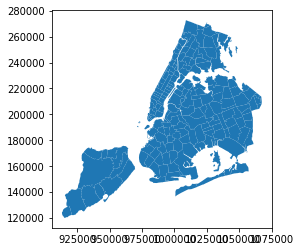

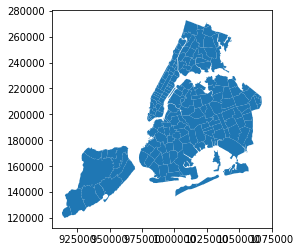

In [8]:
nyczipsshp = gpd.read_file(os.getenv("PUIDATA") + "/ZIP_CODE_040114.shp")
nyczipsshp.plot()
nyczipsshp.drop_duplicates("ZIPCODE").plot()
nyczipsshp
print("ZIPCODES:",
      len(np.unique(nyczipsshp.ZIPCODE)), "POLYGONS:",
      len(nyczipsshp.ZIPCODE),
      "the difference is due to island with same zip as parts of land,",
      "but disjoint shapes")
nyczips = nyczipsshp.ZIPCODE.values.astype(int)
print("number of NYC zip codes:", len(nyczips))

Figure 1. Comparing zipcode plot without duplicatess.

In [9]:
dfs.zip = dfs.zip.astype(float)
dfs.zip = dfs.zip.astype(int)

In [10]:
dfs = dfs[dfs.zip.apply(lambda x: x in nyczips)]

In [11]:
dfs.head()

,ap,ap_nf,city,cty_name,emp,emp_nf,empflag,est,name,qp1,qp1_nf,stabbr,year,zip
2966,3375875,NaN,NaN,NaN,106160,NaN,NaN,6999,"New York, NY",781628,NaN,NaN,1994,10001
2967,258318,NaN,NaN,NaN,13500,NaN,NaN,1784,"New York, NY",60207,NaN,NaN,1994,10002
2968,2194890,NaN,NaN,NaN,59001,NaN,NaN,3256,"New York, NY",497286,NaN,NaN,1994,10003
2969,2615639,NaN,NaN,NaN,39428,NaN,NaN,1115,"New York, NY",685819,NaN,NaN,1994,10004
2970,2937365,NaN,NaN,NaN,43540,NaN,NaN,1076,"New York, NY",807612,NaN,NaN,1994,10005


In [12]:
pivotdf = pd.pivot_table(dfs, values='est', index='zip', columns='year')
pivotdf.dropna(axis=0, inplace=True)
#cleancsb = np.array(pivotdf)
cleancsb = pivotdf.copy()

In [13]:
#then the standardization will look like:
vals = ((cleancsb.T - cleancsb.mean(1)) / cleancsb.std(1)).T

vals.mean(axis=1) should return 0 (or something very small) everywhere

vals.mean(axis=1).shape should be (260,)

vals.std(axis=1) should return 1 everywhere

vals.std(axis=1).shape

In [14]:
nc = 5
km = KMeans(n_clusters=nc, random_state=444).fit(vals)

#each observation in the km object has a label: 
#that is the cluster assigned to that observation
km.labels_.shape

print(km.labels_)

pd.DataFrame(km.labels_)[0].unique()

vals["cluster"] = km.labels_

[0 0 2 2 0 1 0 2 4 0 0 4 0 4 1 2 4 0 4 4 0 0 0 2 2 0 2 2 2 2 0 2 2 4 2 4 2
 0 0 4 2 0 4 4 4 3 3 1 3 1 4 0 2 4 0 3 1 1 4 0 1 4 3 3 3 3 4 4 4 2 3 1 4 2
 1 1 2 4 1 3 1 1 4 2 4 0 1 0 1 0 2 2 2 0 2 2 0 2 0 3 2 0 2 0 2 2 2 2 2 2 2
 2 0 2 2 4 2 0 2 2 2 3 3 2 0 2 2 2 0 1 2 0 2 0 2 2 2 2 2 2 2 2 2 2 2 0 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 3 2 2 0 2 2 2 0 2 2 0 2 2 4
 2 2 2 2 2 2 2 0 2 2 0 2 2 2 2 2 2 0 2 4 0 2 2 2 2 2 2 2 0 3 2 2 0 0 0 0 2
 2 2 4 2 2 2 2 0]


In [15]:
vals.head()

year,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,cluster
zip,,,,,,,,,,,,,,,,,,,,,
10001,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986,0
10002,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077,0
10003,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833,2
10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,2
10005,-2.819347,-2.263972,-0.463213,-0.278088,0.445582,-0.025645,0.731684,0.092162,0.008014,-0.732485,...,0.260457,0.496070,0.799002,0.512900,0.378264,0.967297,0.496070,0.883150,1.303888,0


### The map of the clusters may look something like this

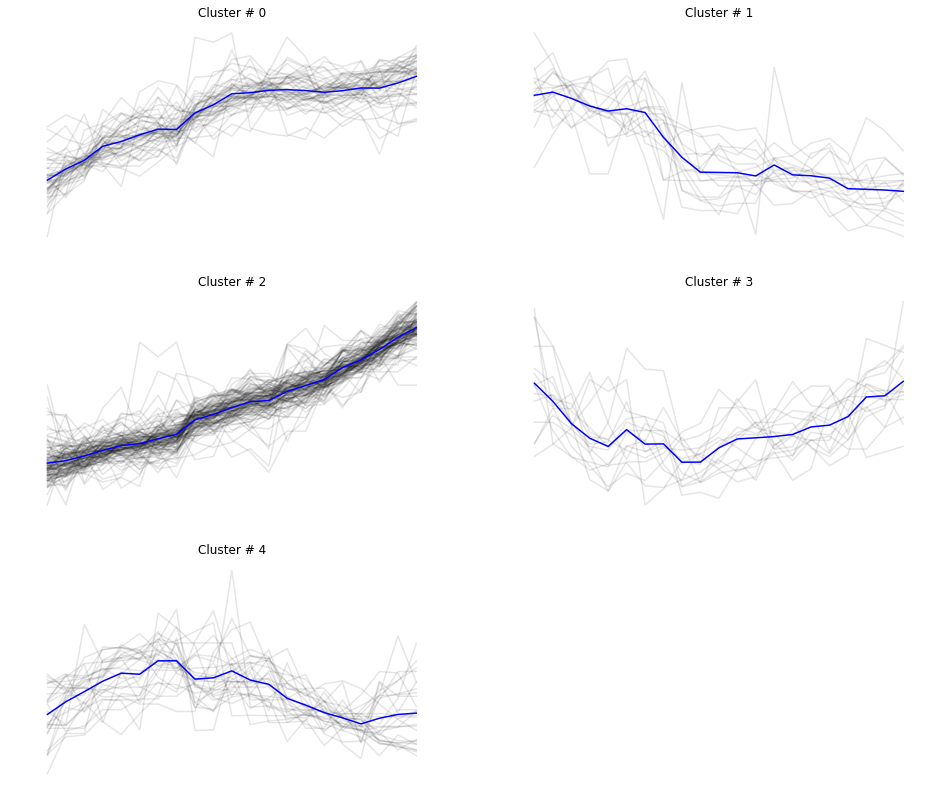

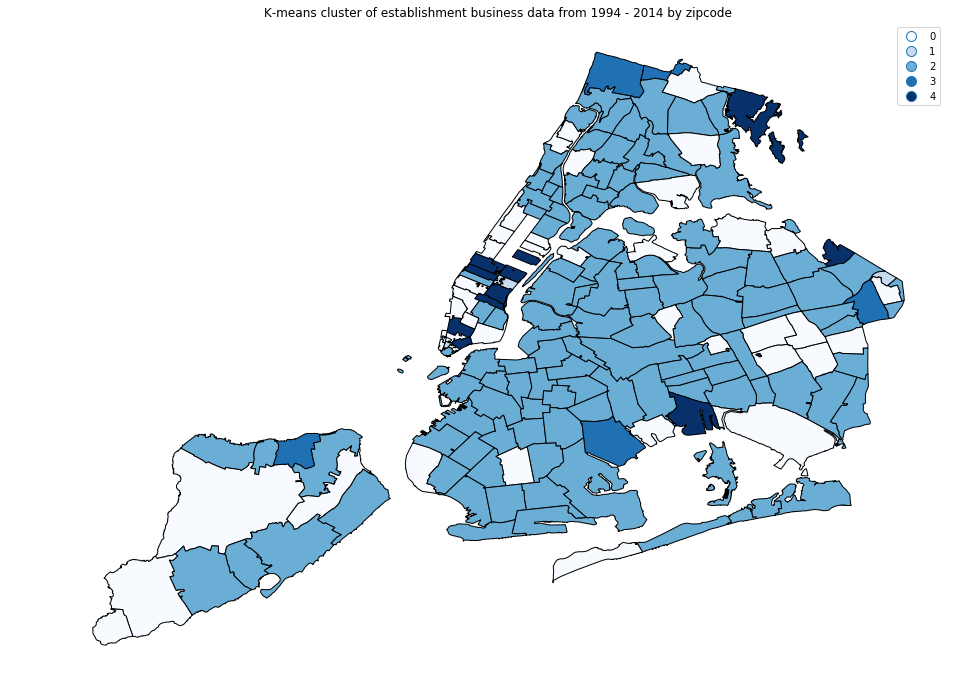

In [16]:
fig = plt.figure(figsize=(16,14))
for i in range(nc):
    cluster = vals[vals['cluster'] == i]
    ax = fig.add_subplot(3,2,i+1)
    ax.plot(range(cluster.shape[1]-1),cluster.iloc[:,:-1].T, 'k-', alpha=0.1)
    ax.plot(range(cluster.shape[1]-1),km.cluster_centers_[i], 'b-')
    ax.set_title('Cluster # {}'.format(i))
    ax.axis("off")

nyczipsshp.ZIPCODE = nyczipsshp.ZIPCODE.astype(int)
kmeans_geo = nyczipsshp.merge(vals[['cluster']], left_on='ZIPCODE', right_index=True)

fig2, ax2 = plt.subplots(figsize=(16,12))

kmeans_geo.plot(ax=ax2, column='cluster', cmap='Blues', edgecolor='k', lw=1,  categorical=True, legend=True)
ax2.set_title('K-means cluster of establishment business data from 1994 - 2014 by zipcode')
ax2.axis('off');

Figure 2. cloropleth of cluster centers for 5 k-means clusters of business patterns (number of businesses) at the zipcode level for NYC zipcodes: each color indicates a cluster. The business pattern time series are plotted at the top.

### or maybe like this, depending on which algorithm you use, and how you proceed to preprocess your data and how you cluster it. There is no one correct answer, but general trends should be retrieved.

In [17]:
nc = 7
km = KMeans(n_clusters=nc, random_state=444).fit(vals)

#each observation in the km object has a label: 
#that is the cluster assigned to that observation
km.labels_.shape

print(km.labels_)

pd.DataFrame(km.labels_)[0].unique()

vals["cluster"] = km.labels_

[6 6 0 0 6 5 6 0 1 6 6 1 6 1 5 0 2 6 2 2 6 6 6 0 0 6 0 0 0 0 6 0 0 1 0 2 0
 6 6 2 4 6 2 2 2 3 3 5 1 5 2 6 4 2 6 3 5 5 2 6 5 2 3 4 3 3 1 2 2 0 3 5 1 0
 5 5 0 2 5 3 5 5 1 4 1 6 5 6 5 6 0 4 0 6 0 0 6 0 6 3 0 6 4 6 0 0 0 0 0 4 0
 0 6 4 4 2 0 6 0 0 0 4 3 4 6 0 0 4 6 5 0 6 4 6 0 0 0 0 4 4 0 4 4 4 0 6 4 0
 4 0 0 0 4 0 0 0 0 4 4 0 0 4 4 4 0 6 0 0 4 4 0 3 4 4 6 0 0 0 6 0 0 6 0 0 1
 0 0 4 0 0 0 0 6 0 0 6 0 4 0 0 4 0 6 0 1 6 0 4 0 0 0 4 0 6 3 0 0 6 6 6 6 0
 0 0 1 0 4 0 0 6]


In [18]:
matplotlib.__version__

'2.1.0'

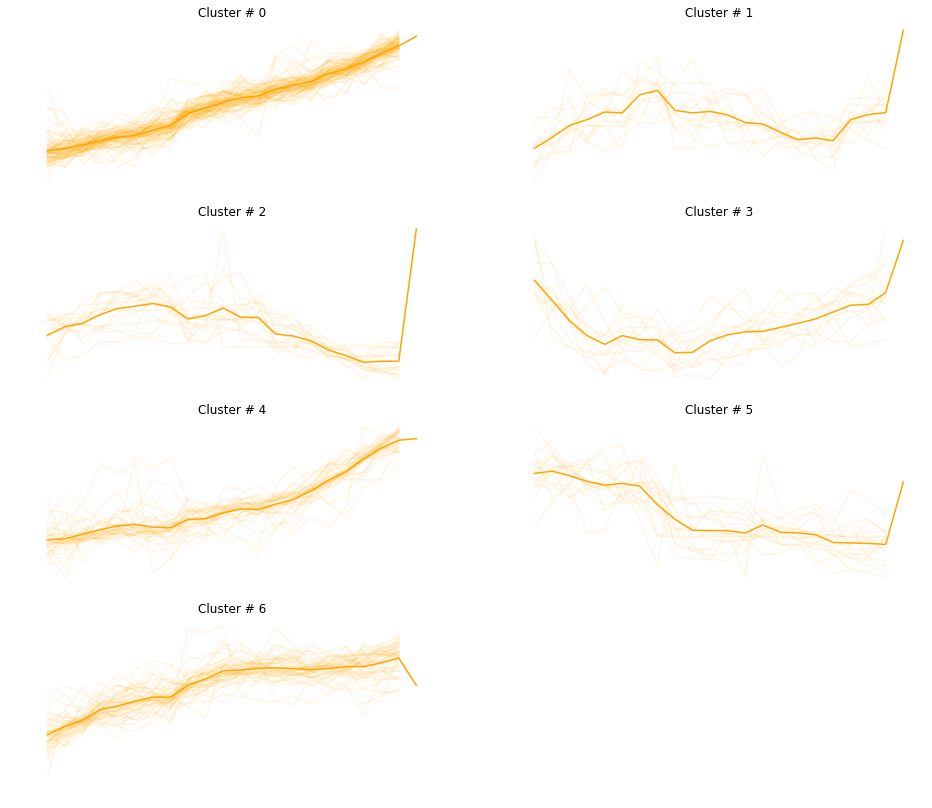

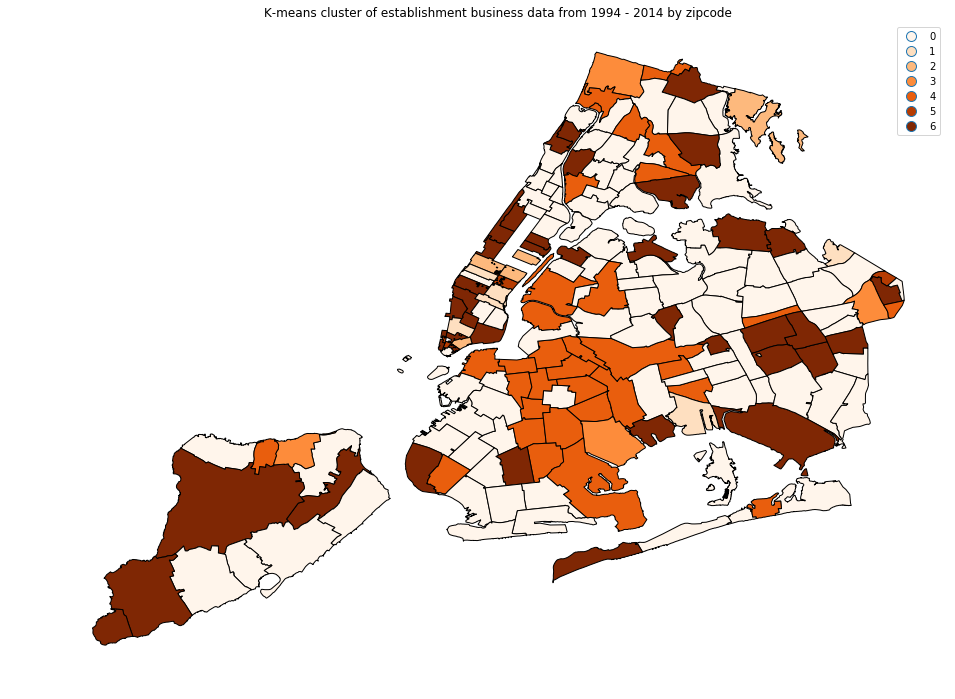

In [19]:
fig = plt.figure(figsize=(16,14))

for i in range(nc):
    cluster = vals[vals['cluster'] == i]
    ax = fig.add_subplot(4,2,i+1)
    ax.plot(range(cluster.shape[1]-1),cluster.iloc[:,:-1].T, 'k-', alpha=0.1, color="Orange")
    ax.plot(range(cluster.shape[1]),km.cluster_centers_[i], 'b-', color="Orange")
    ax.set_title('Cluster # {}'.format(i))
    ax.axis("off")

nyczipsshp.ZIPCODE = nyczipsshp.ZIPCODE.astype(int)
kmeans_geo = nyczipsshp.merge(vals[['cluster']], left_on='ZIPCODE', right_index=True)

fig2, ax2 = plt.subplots(figsize=(16,12))

kmeans_geo.plot(ax=ax2, column='cluster', cmap='Oranges', edgecolor='k', lw=1, categorical=True, legend=True)
ax2.set_title('K-means cluster of establishment business data from 1994 - 2014 by zipcode')
ax2.axis('off');

Figure 3. The plot shows 7 clusters based on establishments business data of NYC by zipcode.

# If you want to use agglomerative clustering

In [20]:
nc = 5
agc = AgglomerativeClustering(n_clusters=nc, linkage='average').fit(vals)
#labelsag = agc.labels_
#centroidsag = np.zeros((nc, vals.shape[1]))

In [21]:
vals["cluster"] = agc.labels_

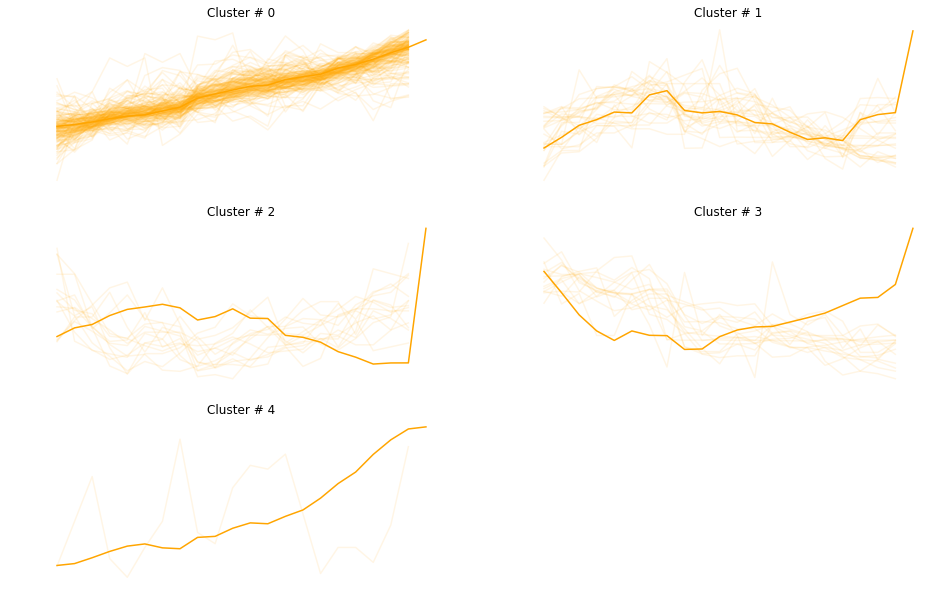

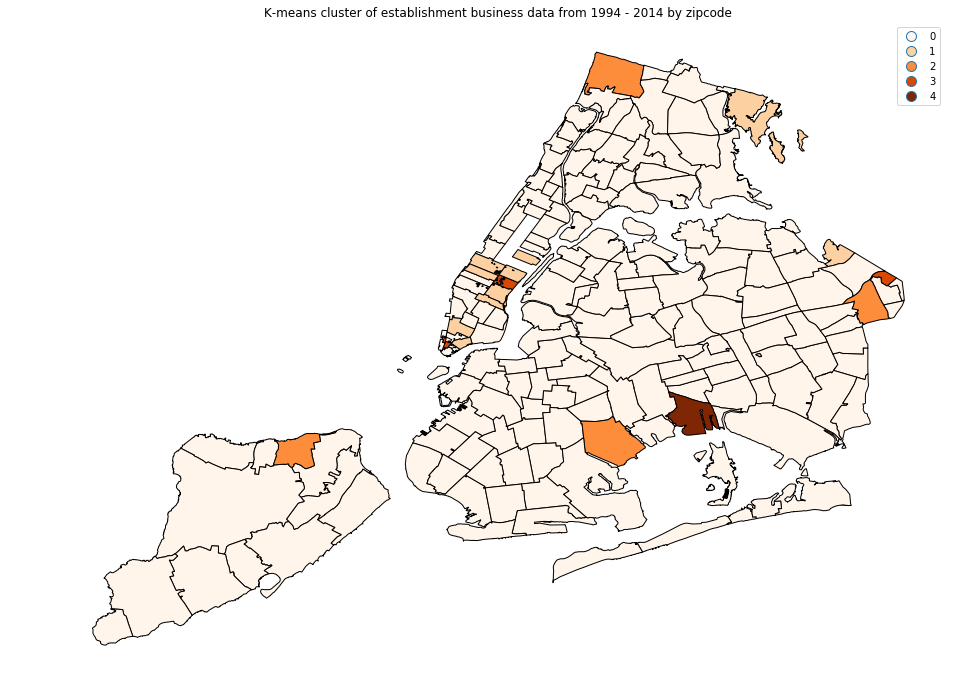

In [22]:
fig = plt.figure(figsize=(16,14))

for i in range(nc):
    cluster = vals[vals['cluster'] == i]
    ax = fig.add_subplot(4,2,i+1)
    ax.plot(range(cluster.shape[1]-1),cluster.iloc[:,:-1].T, 'k-', alpha=0.1, color="Orange")
    ax.plot(range(cluster.shape[1]),km.cluster_centers_[i], 'b-', color="Orange")
    ax.set_title('Cluster # {}'.format(i))
    ax.axis("off")

nyczipsshp.ZIPCODE = nyczipsshp.ZIPCODE.astype(int)
kmeans_geo = nyczipsshp.merge(vals[['cluster']], left_on='ZIPCODE', right_index=True)

fig2, ax2 = plt.subplots(figsize=(16,12))

kmeans_geo.plot(ax=ax2, column='cluster', cmap='Oranges', edgecolor='k', lw=1, categorical=True, legend=True)
ax2.set_title('K-means cluster of establishment business data from 1994 - 2014 by zipcode')
ax2.axis('off');

Figure 4. The plot above is Agllomerative Clustering which shows different areas comparing to Kmeans cluster.

### And if you use hierarchical clustering in scipy you can make a dandrogram it may look like this:

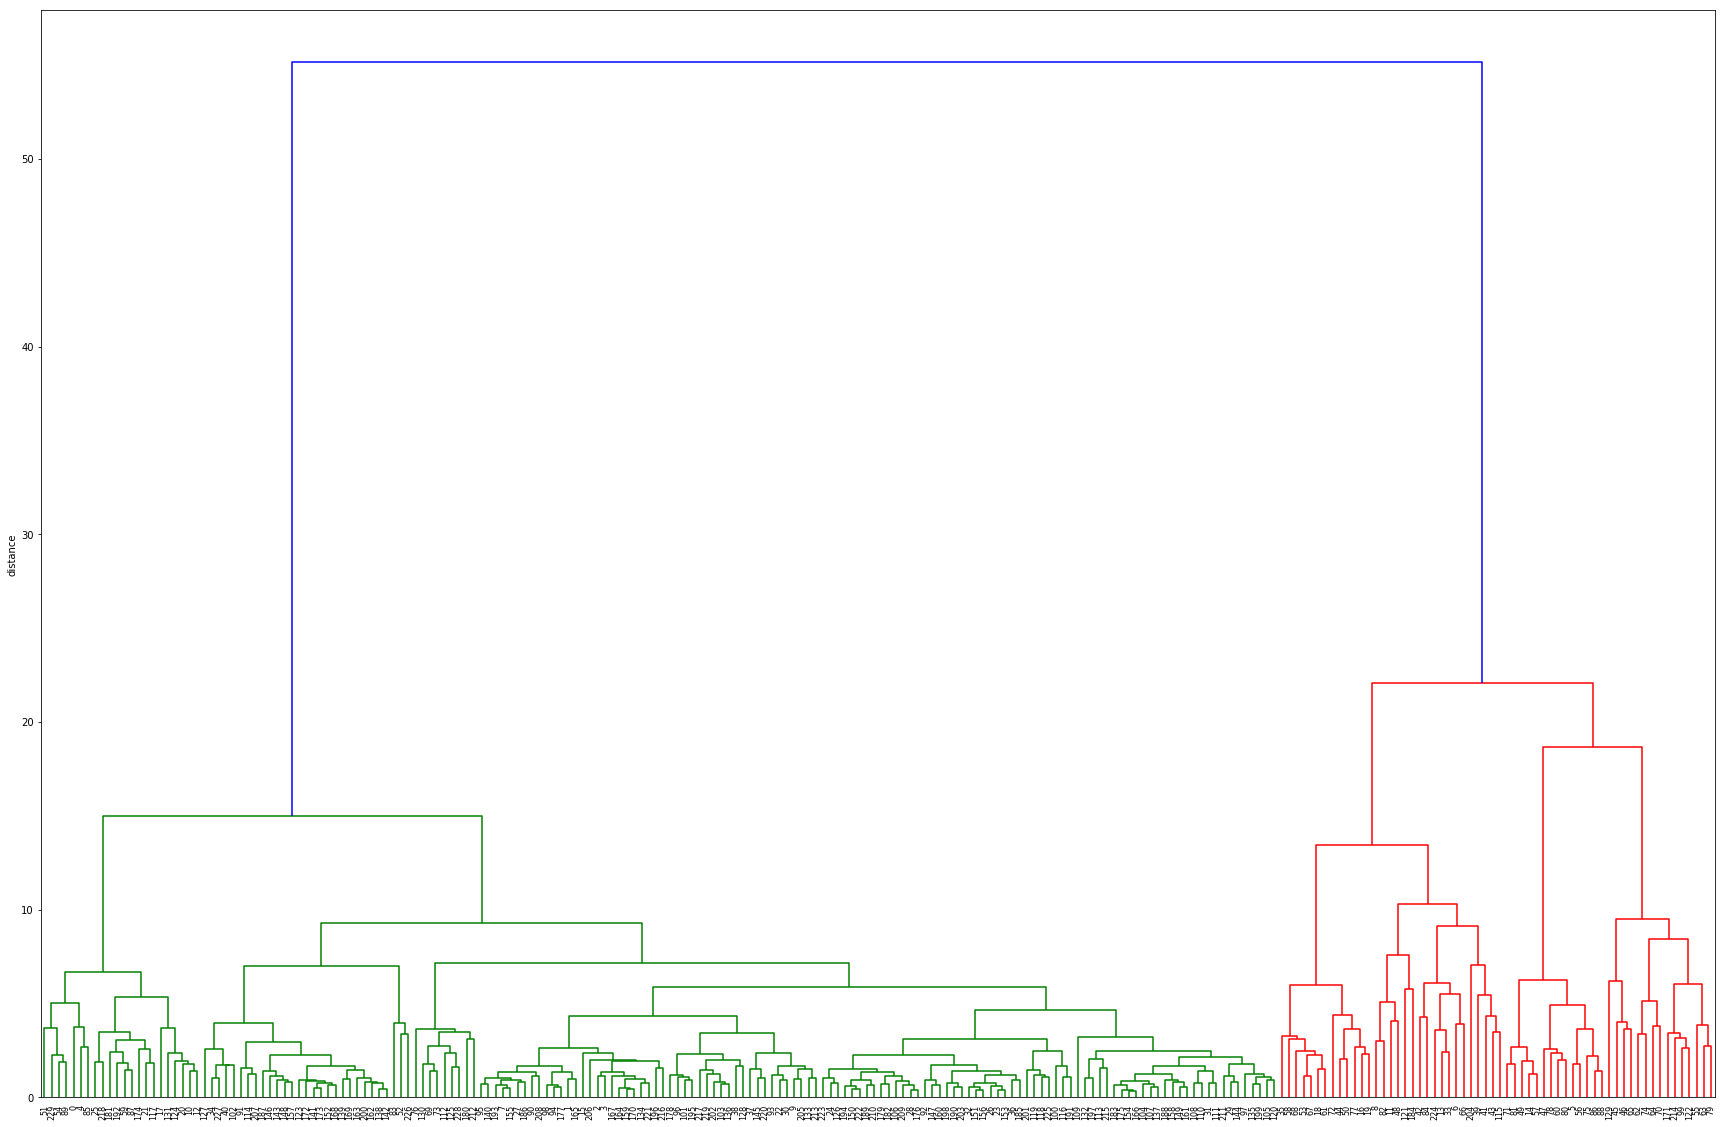

In [26]:
import scipy.cluster as scp
fig = plt.figure(figsize=(30,20))
plt.ylabel("distance")
hier=scp.hierarchy.linkage(vals, method='ward')
ddg =scp.hierarchy.dendrogram(hier,
                               leaf_rotation=90.,  # rotates the x axis labels
                               leaf_font_size=8.)  # font size for the x axis labels)

Figure 5. Dendogram of establishment businesses in NYC.